# Pulse Wave Discrimination




## Overview

### The goal of this project is to analyze datasets containing different waveforms and at the end be able to differentiate between them by successfully implementing a deep learning model. This is done in steps, first we look at the data and try to get a qualitative understaing of the patterns that might be present, which could reveal differences between them. Then we proceed with the conventional template for building the model:  splitting data -->pytorch dataset --> dataloader -->  training /validation --> testing --> inference. This is the general idea, then we will go over the specific questions, like the contamination of the Po and a means for measuring the epistemic uncertainty. The goal is to achieve a minimum test accuracy of 80% or in other words, the model correctly guesses the waveform type (Li or Po) at least 80% of the time.

In [1]:
#IMPORTING LIBRARIES

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchmetrics
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
#Adjusting parameters for plots
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['text.usetex'] = 0

In [2]:
# LOADING FILES
"""
We worked with kaggle kernels as it provides higher ram and it generally works well.
"""
po_file = '/kaggle/input/pulse-discrimination/Po.npz'
li6_file = '/kaggle/input/pulse-discrimination/Li6.npz'
phys_file = '/kaggle/input/pulse-discrimination/Phys.npz'

Po = np.load(po_file)
Li6 = np.load(li6_file)
Phys = np.load(phys_file)

# Checking contents of the files
print("Keys in Po.npz:", list(Po.keys()))
print("Keys in Li6.npz:", list(Li6.keys()))
print("Keys in Phys.npz:", list(Phys.keys()))

Keys in Po.npz: ['data_array']
Keys in Li6.npz: ['data_array']
Keys in Phys.npz: ['data_array']


In [3]:
#Accessing the 'data_array' from each file
"""
For now we access the whole data array from the Li and Po datasets, later on we will do the same for the Phys.
"""
po_data = Po['data_array'][:,:,:]
li6_data = Li6['data_array'][:,:,:]

In [4]:
# checking shapes of each dataset
print("Shape of Po data:", po_data.shape)
print("Shape of Li6 data:", li6_data.shape)


Shape of Po data: (52238, 4, 7756)
Shape of Li6 data: (53000, 4, 7756)


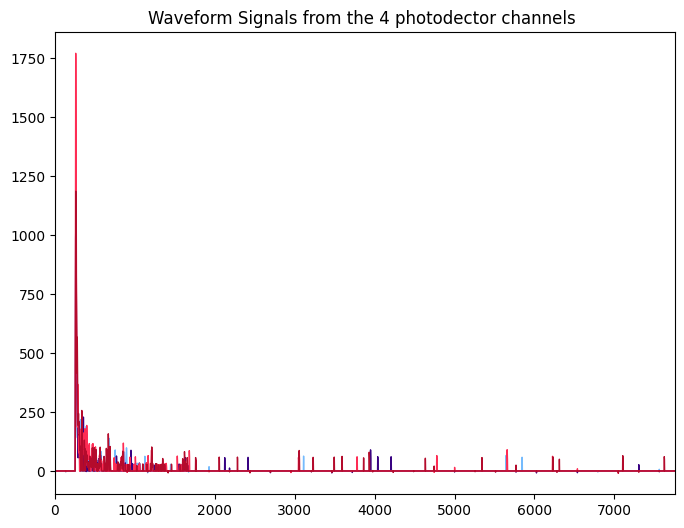

In [5]:
# Having a look at the different wave forms
"""
We access a random signal from each of the 4 photodetector channels, and display it using matplotlib
"""
j = np.random.randint(0,len(po_data))
plt.plot(po_data[j][0],color='#75bbfd',lw=1)
plt.plot(po_data[j][1],color='#380282',lw=1)
plt.plot(po_data[j][2],color='#fe2c54',lw=1)
plt.plot(po_data[j][3],color='#b40b2c',lw=1)
plt.title("Waveform Signals from the 4 photodector channels ")
plt.xlim(0,7756)
plt.show()

In [6]:
# Inspecting datsets
"""
We started doing this by looking at the shapes, but we can delve deeper into the datasets
"""

# Understanding the shapes of the datasets
"""
Shape of Po data: (52238, 4, 7756)
Shape of Li6 data: (53000, 4, 7756)
Shape of Phys data: (24000, 4, 7756)

Those were the shapes found, the first number represents examples of some signal, the second represents the number of photodector, and hence the last number would be
the amplitudes at different time stamps, hence we have for Po data for example: 52238 events, recorded by 4 different photodectors (each records it with a different waveform)
and each event has 7756 amplitude values.
"""

# Checking some values for a particular event detected by a particular detector

event_idx = 1000  # Event index
detector_idx = 3  # detector index (we could choose between 0,1,2,3)

waveform = li6_data[event_idx, detector_idx]
print(waveform[100:201]) #printing first 100 values from the possible 7756 values

[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    3.672 0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.   ]


## First Question:  Explore the datasets and provide some qualitative method to show the differences between the two type of signals. Explain what feature you have found for discrimination if any

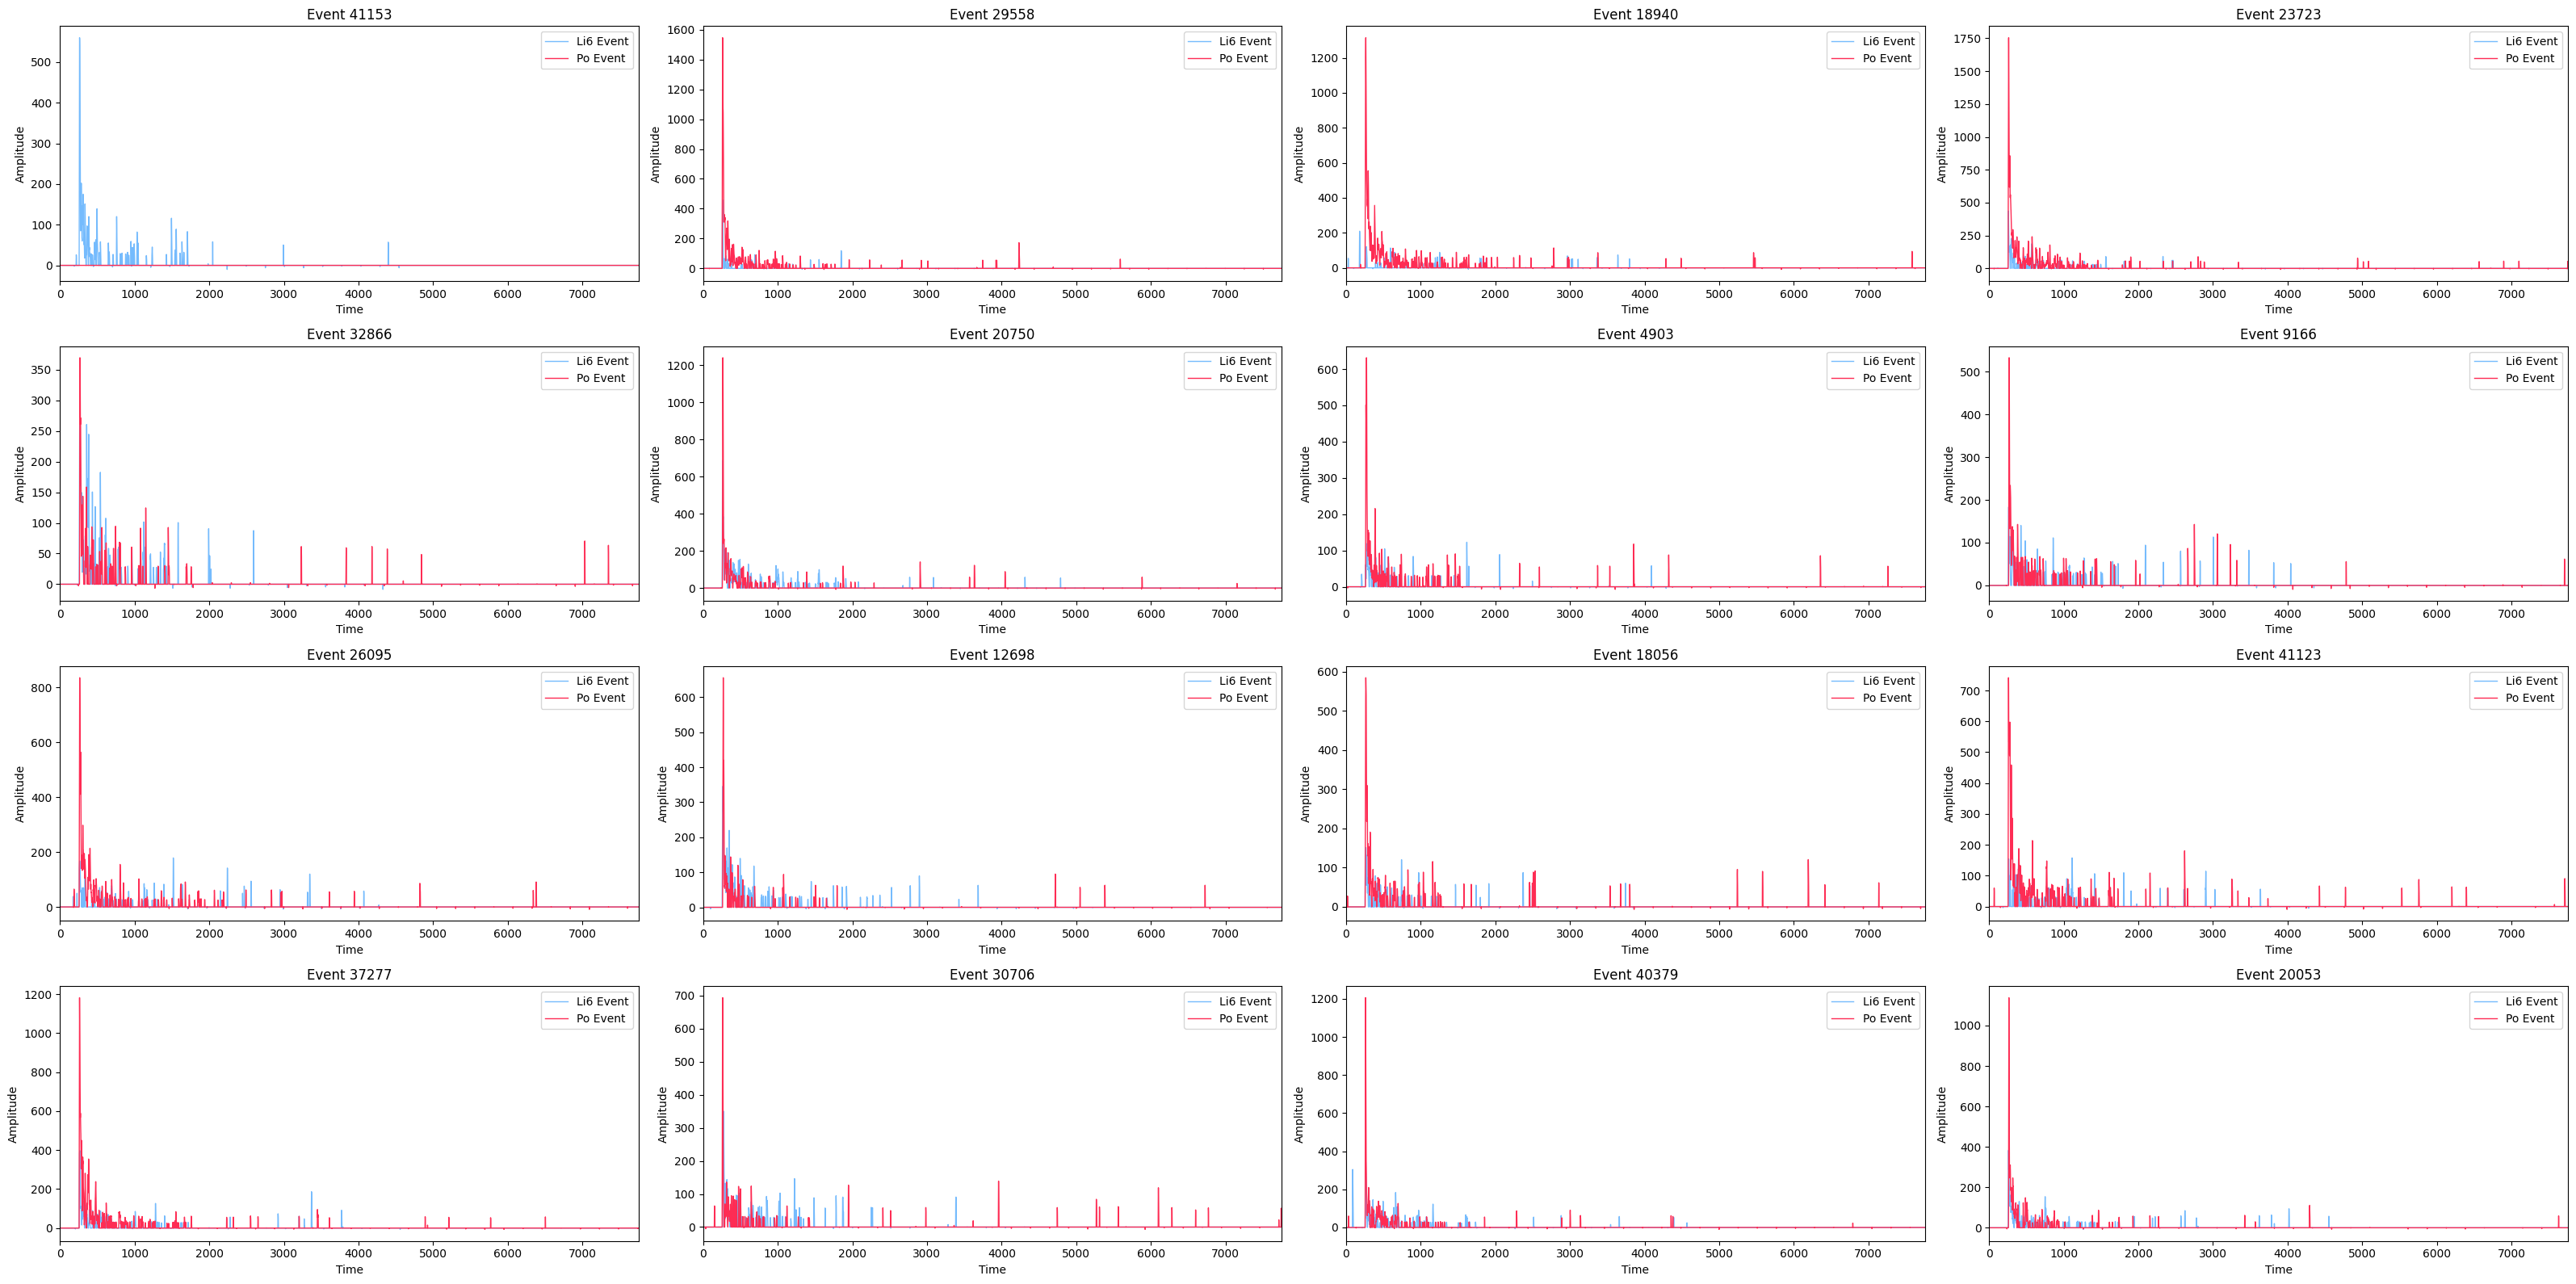

In [7]:
#Solution first question part 1

"""
Now that we have an idea of what the data in our datasets represents, we want to distinguish qualittively between the Li6 signal which we want to recognize
and the Po signal which is contamination, we can start by plotting some event for Li6 and Po from the same detector and do it for random events multiple times, and overlap
the plots, to see if there is any pattern, we can use to differentiate them qualitatively
"""


num_events = 16 #Number of events to be plotted
num_cols = 4  # Number of columns
num_rows = 4  # Number of rows

event_indices = np.random.randint(0, po_data.shape[0], size=num_events) #choosing po_data as it has less rows, if we choose li6, there might be small chance an index like 52980 would pop which is out of range for po
fig, axes = plt.subplots(num_rows, num_cols, figsize=(32, 16))
for i, event_idx in enumerate(event_indices):
    row = i // num_cols
    col = i % num_cols
    li6_event = li6_data[event_idx, 0]  # Li6, first detector/channel
    po_event = po_data[event_idx, 0]    # Po, first detector/channel
    axes[row, col].plot(li6_event, color='#75bbfd', lw=1, label='Li6 Event')
    axes[row, col].plot(po_event, color='#fe2c54', lw=1, label='Po Event')
    axes[row, col].set_title(f"Event {event_idx}")
    axes[row, col].set_xlim(0, 7756)
    axes[row, col].set_xlabel("Time")
    axes[row, col].set_ylabel("Amplitude")
    axes[row, col].legend(loc="upper right")
plt.tight_layout()
plt.show()

In [8]:
#Solution first question part 2

"""
From the plots we can observe a clear pattern where at large time stamps, there is no peaks for the Li6 datasets, only rarely after rerunning multiple time, you get 1 out of the 16 plots having a blue peak (li6)
at larger time stamps (larger like after time = 5000 for example), hence qualitaitvely, to differentiate, we would just look at the tails of the signal and see if there are any peaks (even if small), if there are
then it corresponds to Po if there are not than it corresponds to li6 probably, with high chance.
"""

"""
We can try to do just a small quantitive check, by looking at all possible events from each dataset and for all 4 channels (as in the plots we plotted only the first channel/detector events), and this is by
introducing a time threshold, and check for the values of the amplitudes after that threshold, if our qualitiave analysis is correct, there should be a large number of events with really small amplitudes
(almost zero or zero, or in other words not observable with the eye clearly) for li6 after this threshold, and small number of events with really small amplitudes for Po after this threshold.
"""

time_threshold = 6000 #threshold defined - arbitrary high value (from plots it seems higher than 4500 should be good, but 6000 just to be sure, in general values from 4500 to 6000 should work.)

# Slicing the Po dataset to include only the values after time theshold
li6_data_after_threshold = li6_data[:, :, time_threshold:] #basically all data points after timethreshold
po_data_after_threshold = po_data[:, :, time_threshold:]

# Calculate the maximum amplitude after the threshold for each event and channel
max_amplitude_after_threshold = np.max(li6_data_after_threshold, axis=(1, 2)) #taking the maximum amplitude after time threshold for each of the events
max_amplitude_after_threshold2 = np.max(po_data_after_threshold, axis=(1, 2))

# Checking how many events have no or very small amplitude after time threshold

small_amplitude_threshold = 50  # Example threshold - arbitrary small value

events_with_small_amplitude = np.sum(max_amplitude_after_threshold < small_amplitude_threshold) #checking the number of events that after time satisfy this inequalitry
events_with_small_amplitude2 = np.sum(max_amplitude_after_threshold2 < small_amplitude_threshold)
# Print the results
print(f"Number of events with small amplitudes (less than small_amplitude threshold) after time_threshold ( Li): {events_with_small_amplitude} out of {li6_data.shape[0]}")
print(f"Number of events with small amplitudes (less than small_amplitude threshold) after time_threshold (Po): {events_with_small_amplitude2} out of {po_data.shape[0]}")

"""
Indeed, for Li6 we have almost all the events having really small amplitude (unobservable by the eye), while for Po just a small fration (~ 1%) does not have an observable peak, or in other words after a certain time threshold, there are few almost negligible number of visible peaks for Li,
While there for almost all waveforms visible amplitudes for Po, confirming our qualitative analysis.
"""

Number of events with small amplitudes (less than small_amplitude threshold) after time_threshold ( Li): 51845 out of 53000
Number of events with small amplitudes (less than small_amplitude threshold) after time_threshold (Po): 604 out of 52238


'\nIndeed, for Li6 we have almost all the events having really small amplitude (unobservable by the eye), while for Po just a small fration (~ 1%) does not have an observable peak, or in other words after a certain time threshold, there are few almost negligible number of visible peaks for Li,\nWhile there for almost all waveforms visible amplitudes for Po, confirming our qualitative analysis.\n'

### When we tried to work with these data given the large number of samples, it was really slow, and didn't give best results, so after thinking, we tried to use some dimension reduction techniques like fourier transform (when creating the torch dataset) which should solve the problem, but it didn't work well, so we decided to use the results from the qualitiave analysis, mainly that the relevant differences can be seen from just a subset of the amplitudes (the ones at the tail), hence we reinitialize the li6_data and po_data, to consider only that interval, in this way the training goes faster, and no need to implement any dimension reduction.

In [9]:
# Deleting Li and Po data, and reinitialising them taking into account less amplitudes
del li6_data
del po_data

In [10]:
# Reinitalsiing the li6 and po data

po_data = Po['data_array'][:,:,5000:6000] # the interval chosen was from 5000 to 6000, it was chosen after trial and error, but also from 4500 to 6000 or 5500 to 7000 and so on could have worked, important thing is that it is that it the last values (after 4500)
li6_data = Li6['data_array'][:,:,5000:6000]
print("Shape of Po data:", po_data.shape)
print("Shape of Li6 data:", li6_data.shape)

Shape of Po data: (52238, 4, 1000)
Shape of Li6 data: (53000, 4, 1000)


## Format of the data used for qualitative check

In [11]:
# Lets check the format of our input datsets
print(f"Format of Li6 dataset: {type(li6_data)}")
print(f"Format of Po dataset: {type(po_data)}")

"""
The format of all the datsets was np arrays, so all are 3D numpy arrays, however when creating the dataset and the model, we will have to convert the numpy arrays to torch tensors.
"""

Format of Li6 dataset: <class 'numpy.ndarray'>
Format of Po dataset: <class 'numpy.ndarray'>


'\nThe format of all the datsets was np arrays, so all are 3D numpy arrays, however when creating the dataset and the model, we will have to convert the numpy arrays to torch tensors.\n'

## Torch Dataset creation

### Now the first step to take towards training the model is to define a torch dataset which is useful to arrange properly our data to then feed it into the dataloader

In [12]:
# First we have to create a pytorch dataset by defining a class, we will call it "SignalsDataset", The SignalsDataset class is a subclass of torch.utils.data.Dataset


"""
The SignalsDataset class takes as input the data (Li or po or phys) and the labels of each sample (we will create them later on).
"""
class SignalsDataset(Dataset):
    def __init__(self, data, labels=None):
        print("Initializing dataset...")
        self.data = torch.stack([torch.tensor(data[i], dtype=torch.float32) for i in tqdm(range(len(data)), desc="Processing data")]) # tqdm for tracking, and torch.tensor to convert the data from numpy arrays to torch tensors.
        self.labels = (
           torch.tensor(labels, dtype=torch.long) if labels is not None else None
        )

    def __len__(self):
        return len(self.data) # returns number of samples in the dataset

    def __getitem__(self, idx):
        sample = self.data[idx]
        if self.labels is not None:
            label = self.labels[idx]
            return sample, label
        else:
            return sample

"""
The importance of this dataset class is that prepares my data (in this case the Li6 and Po datsets and phys) to be easily accessed during training, if we create a DataLoader object
and give it an instance of this clss; The DataLoader will handle batching the data, shuffling it, and loading it efficiently.
"""


'\nThe importance of this dataset class is that prepares my data (in this case the Li6 and Po datsets and phys) to be easily accessed during training, if we create a DataLoader object\nand give it an instance of this clss; The DataLoader will handle batching the data, shuffling it, and loading it efficiently.\n'

## Splitting the data & Initialising datasets and dataloaders

In [13]:
# Before we split the data we have first to combine the Li6 dataset with the Po dataset and giving labels to each (for example 0 to Po and 1 for Li6), after that we can split our dataset.

"""
The datasets are joined and given a label so that the model can be trained.
"""

li6_labels = np.ones(len(Li6['data_array'][:,:,5000:6000]))  # Li6 data is labelel with 1
po_labels = np.zeros(len(Po['data_array'][:,:,5000:6000]))  # Po data is labeled with 0

data_combined = np.concatenate((Li6['data_array'][:,:,5000:6000], Po['data_array'][:,:,5000:6000]), axis=0) # joining the li6 and po datasets
labels_combined = np.concatenate((li6_labels, po_labels), axis=0) # joining the labels of each dataset

print("Combined data shape:", data_combined.shape)
print("Combined labels shape:", labels_combined.shape)

Combined data shape: (105238, 4, 1000)
Combined labels shape: (105238,)


In [14]:
# To free up ram we can get rid df some of the unused variable

del po_data
del li6_data
del li6_labels
del po_labels

In [15]:
# Splitting the data 80-10-10 (another way would be 70-20-10 or 70-15-15. The dataset is large, so allocating 80% to training ensures the model has sufficient data for learning, while 10% each for validation and testing provides adequate data for model tuning and performance evaluation.

data_train, data_temp, labels_train, labels_temp = train_test_split(data_combined, labels_combined, test_size=0.2, random_state=42)
data_val, data_test, labels_val, labels_test = train_test_split(data_temp, labels_temp, test_size=0.5, random_state=42)

# Initialisation of datsets
train_dataset = SignalsDataset(data_train, labels_train)
val_dataset = SignalsDataset(data_val, labels_val)
test_dataset = SignalsDataset(data_test, labels_test)

# Initialisation of DataLoaders for batching and shuffling
batch_size = 32 # other options like 64 or 128 are fine as well
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # shuffling was set to true for training which is conventional to prevent the model from learning a pattern based on the order of the data
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Initializing dataset...


Processing data: 100%|██████████| 84190/84190 [00:02<00:00, 32152.60it/s]


Initializing dataset...


Processing data: 100%|██████████| 10524/10524 [00:00<00:00, 86947.42it/s]


Initializing dataset...


Processing data: 100%|██████████| 10524/10524 [00:00<00:00, 85950.39it/s]


In [16]:
# CHECKING IF SHAPES ARE CORRECT AFTER DATALOADER

for batch_idx, (batch_data, batch_labels) in enumerate(train_loader):
    print(f"Batch {batch_idx+1}")
    print(f"Data shape: {batch_data.shape}")  # Expected: torch.Size([batch_size, 4, 1000])
    print(f"Labels shape: {batch_labels.shape}")  # Expected: torch.Size([batch_size])
    break  # Just to inspect the first batch

Batch 1
Data shape: torch.Size([32, 4, 1000])
Labels shape: torch.Size([32])


In [17]:
# Access the first sample in the training dataset
sample, label = train_dataset[0]
print("Sample shape:", sample.shape)  # shape should be: (4, 1000)
print("Label:", label)  # 0 or 1

# Checking the length of the splitted  datasets, to confirm right splitting
print("Training set size:", len(train_dataset))
print("Validation set size:", len(val_dataset))
print("Test set size:", len(test_dataset))

Sample shape: torch.Size([4, 1000])
Label: tensor(1)
Training set size: 84190
Validation set size: 10524
Test set size: 10524


In [18]:
# Given that we already initialised dataloaders which will be used for the training and testing, we don't need 'data_combined' anymore
del data_combined

## Defining Model/Classifier

#### Now that we have our dataloaders ready, we have to define the model to be trained with our data, Given that we are working with waveforms, which can be seen as figures or pictures in a certain sense, we thought of trying a Convolusional Neural Network (CNN).

In [19]:
# Different CNNs were tried, this one worked relatively well with 3 convolusional layer and two batch normalization layers along with two pooling and two fully connected layers, also dropiut was added to decrease
# probability of overfitiing, there is also option to decrease number of layers but increase number of channels to compensate ( to have somewhat the same number of paramters).



class EnhancedCNN(nn.Module):
    def __init__(self):
        super(EnhancedCNN, self).__init__()
        # Convolutional Layers with fewer channels
        self.conv1 = nn.Conv1d(4, 12, kernel_size=7, stride=1, padding=3) # first convolusional layer
        self.bn1 = nn.BatchNorm1d(12) # first batch normalization
        self.conv2 = nn.Conv1d(12, 24, kernel_size=5, stride=1, padding=2) # second sonvolusioanl layer
        self.bn2 = nn.BatchNorm1d(24) # second batch normalization
        self.pool = nn.MaxPool1d(4, stride=4)  # first pooling layer

        # Additional Convolution Layer
        self.conv3 = nn.Conv1d(24, 48, kernel_size=3, stride=1, padding=1) # third convolusional layer
        self.pool2 = nn.MaxPool1d(4, stride=4) # second pooling layer

        # Fully Connected Layers with droput
        self.fc1 = nn.Linear(48 * 62, 64)  # Input adjusted for pooling 
        self.fc2 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.5) # it randomly removes 50% of the neurons, to prevent overfitting

    def forward(self, x):
        # Pass input through the first convolutional layer, apply ReLU activation and batch normalization
        x = F.relu(self.bn1(self.conv1(x))) # ReLU activation introduces non-linearity
        x = F.relu(self.bn2(self.conv2(x)))  # ReLU activation after second convolutional layer
        
        x = self.pool(x) # Apply max pooling to reduce spatial size (downsampling)
        
        x = F.relu(self.conv3(x)) # Pass through the third convolutional layer and apply ReLU activation
        x = self.pool2(x)  # Apply second pooling layer
        
        x = x.view(x.size(0), -1)  # Flatten the output for the fully connected layers
        x = F.relu(self.fc1(x)) # Pass through the first fully connected layer, apply ReLU activation
        x = self.dropout(x) # dropout is applied to prevent overfitting
        x = torch.sigmoid(self.fc2(x)) # Sigmoid maps the output to a value between 0 and 1
        
        return x # Return the output (sigmoid value for binary classification)


In [20]:
#To check number of trainable parameters, we define a function for the calculation of the total number of parameters in the model

"""
The function takes as input an instance of the classifier class and returns the total number of parameters.
"""

def total_num_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


model = EnhancedCNN()  #initializing model
num_params = total_num_parameters(model)
print(f"Number of trainable parameters: {num_params}")


Number of trainable parameters: 195981


## Training the model

### After having prepared our data into dataloaders, we can now start the training, to do this we have to initialise the model, define a criterion/cost function/loss_function and then an optimizer (SGD, ADAM,...)

In [21]:
#Initialising model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #Kaggle doesn't offer gpu, but in general it is good practice to move to gpu if there is one.
model = EnhancedCNN().to(device) # initialsiing model


In [22]:
criterion = nn.BCELoss() # we use binary cross entropy as we are working with binary classification (distinguising between li and po signal)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5) # Adam overll is a good option for binary classification, hence it was chosen


### Now that we initialised model and defined optimizer and criterion, we can start the training. This is done by a training loop, and we will also check the validation loop, to make sure when we can stop training, which typically should be done when validation loss starts to plateau. For each iteration we will calculate the train loss and the validation loss, and for last epoch we will also calculate the train accuracy and validation accuracy. In another cell below, we did the same calculations but instead of calculating the test accuracy and validation accuracy for last epoch only, we did it for all epochs so that we can make a plot in the end. WARNING: It takes a relatively long time, so in case you want to check train loss and val loss only and just know final train and val accuracies run the cell below, if the full calculation of all the aforementioned metrics is desired for all epochs, run the cell after that.

In [23]:
num_epochs = 10  # defining number of cycles/epochs.
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    print(epoch)
    model.train()
    running_loss = 0.0
    all_preds_train = []
    all_labels_train = []
    train_loader_tqdm = tqdm(train_loader, desc="Training", leave=False)  # Training progress bar
    for data, labels in train_loader_tqdm:
        data, labels = data.to(device), labels.to(device).float().unsqueeze(1)  # Move data to device
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        preds = (outputs > 0.5).int()  # Convert probabilities to binary predictions
        all_preds_train.extend(preds.cpu().numpy())
        all_labels_train.extend(labels.cpu().numpy())

        # Update tqdm description with running average loss
        train_loader_tqdm.set_postfix(loss=running_loss / (train_loader_tqdm.n + 1))
    
    # Calculate epoch-level metrics
    train_accuracy = accuracy_score(all_labels_train, all_preds_train)
    train_accuracies.append(train_accuracy)
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    all_preds_val = []
    all_labels_val = []
    val_loader_tqdm = tqdm(val_loader, desc="Validation", leave=False)
    with torch.no_grad():
        for data, labels in val_loader_tqdm:
            data, labels = data.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(data)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = (outputs > 0.5).int()  # Convert probabilities to binary predictions
            all_preds_val.extend(preds.cpu().numpy())
            all_labels_val.extend(labels.cpu().numpy())

            # Update tqdm description with running average loss
            val_loader_tqdm.set_postfix(loss=val_loss / (val_loader_tqdm.n + 1))
    
    # Calculate epoch-level metrics
    val_accuracy = accuracy_score(all_labels_val, all_preds_val)
    val_accuracies.append(val_accuracy)
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    print(f"Train accuracy: {train_accuracy:.4f},  Validation accuracy: {val_accuracy:.4f}")


0


Epoch [1/10], Train Loss: 0.1004, Val Loss: 0.0684
Train accuracy: 0.9793,  Validation accuracy: 0.9867
1


Epoch [2/10], Train Loss: 0.0689, Val Loss: 0.4169
Train accuracy: 0.9862,  Validation accuracy: 0.7815
2


Epoch [3/10], Train Loss: 0.0620, Val Loss: 0.0493
Train accuracy: 0.9882,  Validation accuracy: 0.9891
3


Epoch [4/10], Train Loss: 0.0602, Val Loss: 0.0511
Train accuracy: 0.9886,  Validation accuracy: 0.9893
4


Epoch [5/10], Train Loss: 0.0575, Val Loss: 0.0506
Train accuracy: 0.9888,  Validation accuracy: 0.9899
5


Epoch [6/10], Train Loss: 0.0545, Val Loss: 0.0603
Train accuracy: 0.9895,  Validation accuracy: 0.9901
6


Epoch [7/10], Train Loss: 0.0548, Val Loss: 0.0576
Train accuracy: 0.9895,  Validation accuracy: 0.9902
7


Epoch [8/10], Train Loss: 0.0531, Val Loss: 0.0532
Train accuracy: 0.9896,  Validation accuracy: 0.9899
8


Epoch [9/10], Train Loss: 0.0514, Val Loss: 0.0500
Train accuracy: 0.9900,  Validation accuracy: 0.9901
9


Epoch [10/10], Train Loss: 0.0519, Val Loss: 0.0499
Train accuracy: 0.9898,  Validation accuracy: 0.9890


### Based on the results of training it is reasonable to stop at epoch 8, and here is why: As the validation loss is at its lowest (0.0495) and validation accuracy peaks (0.9901). Beyond this, validation loss starts increasing, and accuracy remains stable, indicating potential overfitting. Early stopping here ensures a good balance between performance and generalization without unnecessary computation. The results may vary somewhat for different runs, but the behavior should be similar, a plot is drawn in one of the following cells to show the behavior described for loss and accuracy. We had some issues with the validation at the start where we observed huge spike in loss and huge spkies down in accuracy, those were adjusted by adding weight decay in the optimizer, which is used for regularization and also increased the dropout from 0.3 to 0.5 in the EnhancedCNN classifier.

In [ ]:
# After training if you want to free up some ram again, run this cell

del train_loader
del val_loader
del test_loader
del train_dataset
del val_dataset
del test_dataset

## Testing phase

### Now that we completed training and validation, resulting in good values of training and validation loss, we have to put the model to the test with unseen data, to see if it can differentiate between them properly, we will also calcuate other relevant statistics like precision (purity) recall (efficiency) and f1_score.

In [29]:
# TEST LOOP

model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    test_loader_tqdm = tqdm(test_loader, desc="Testing", leave=False)
    for data, labels in test_loader_tqdm:
        data, labels = data.to(device), labels.to(device)
        outputs = model(data)
        preds = (outputs > 0.5).int()  # This is to convert probabilities to binary predictions, we put the threshold as customary to 0.5.
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        # This will show the current accuracy while iterating through the batches
        test_loader_tqdm.set_postfix({'Batch': len(all_preds), 'Preds': len(all_preds)})

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")


Test Accuracy: 0.9879
Precision: 0.9914, Recall: 0.9849, F1 Score: 0.9881


In [32]:
# Converting accuracies to percentages

train_accuracies = np.array(train_accuracies)*100
val_accuracies = np.array(val_accuracies)*100

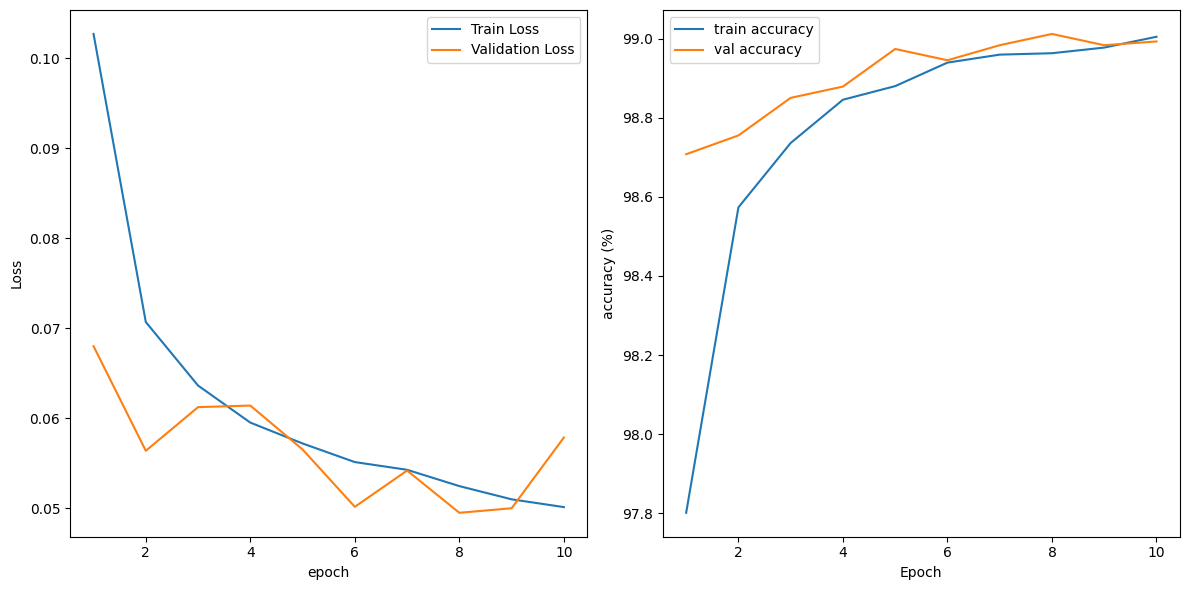

In [33]:
# Plotting losses and accuracies

epochs =  np.arange(1, num_epochs + 1)
fig, axes = plt.subplots(1, 2, figsize=(12, 6)) 

axes[0].plot(epochs,train_losses, label="Train Loss")
axes[0].plot(epochs,val_losses, label="Validation Loss")
axes[0].set_title('')
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()


train_accuracies = np.array(train_accuracies)
val_accuracies = np.array(val_accuracies)
axes[1].plot(epochs, train_accuracies, label ='train accuracy')
axes[1].plot(epochs, val_accuracies, label = 'val accuracy')
axes[1].set_title('')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('accuracy (%)')
axes[1].legend()
plt.savefig("loss_and_accuracy_plots.png")

plt.tight_layout() 
plt.show()


## Contamination of 5% limit

### Our goal is to have a purity (precision) of 95% in recognizing Li signals, but at the same time maximizing the efficieny (recall) of the Li signals, hence we will play with the sensitvity in labeling the waveforms as Li or po, and this is done by manipulating the threshold, typically the threshold is 0.5, if predicted output probability higher than or equal 0.5 it is labeled 1 (Li in our case) and if it is lower than 0.5 it is labeled 0 (Po), so what we can do is to iterate over all the possible thresholds, and calculate the purity(presicion) in identifying Li and the efficiency in doing that, once we obtain a 95% precision with the highest efficiency possible, we will use that thrshold.

In [34]:
# Contamination check via pecision and recall calculations

model.eval()
probabilities = []
all_labels = []

with torch.no_grad():
    for data, labels in tqdm(test_loader, desc="Test Loop", leave=False):
        data, labels = data.to(device), labels.to(device)
        outputs = model(data)
        probs = outputs.cpu().numpy().flatten() 
        probabilities.extend(probs)
        all_labels.extend(labels.cpu().numpy())


probabilities = np.array(probabilities)
all_labels = np.array(all_labels)


thresholds = np.linspace(0, 1, 101)  # 101 thresholds from 0 to 1, so we take two numbers after decimal place.
best_threshold = 0
best_precision = 0
best_recall = 0

# Trying to look for threshold that gives precision of 95% and maximises recall
for threshold in tqdm(thresholds, desc="Threshold Search", leave=False):
    preds = (probabilities > threshold).astype(int)  # Apply threshold
    precision = precision_score(all_labels, preds, zero_division=0)
    recall = recall_score(all_labels, preds)
    
    if precision >= 0.95:  # To make sure precision meets 95% purity
        if recall > best_recall:  # Maximize recall
            best_precision = precision
            best_recall = recall
            best_threshold = threshold

#Printing the relevant metrics
print(f"Optimal Threshold: {best_threshold:.2f}")
print(f"Precision (Purity) at this threshold: {best_precision:.4f}")
print(f"Recall (Efficiency) at this threshold: {best_recall:.4f}")


final_preds = (probabilities > best_threshold).astype(int)
accuracy2 = np.mean(final_preds == all_labels)
precision = precision_score(all_labels, final_preds, zero_division=0)
recall = recall_score(all_labels, final_preds)
f1 = f1_score(all_labels, final_preds)


print(f"Test Accuracy: {accuracy2*100:.4f}%")
print(f"Precision: {precision*100:.4f}%, Recall: {recall*100:.4f}%, F1 Score: {f1*100:.4f}")


Optimal Threshold: 0.08
Precision (Purity) at this threshold: 0.9502
Recall (Efficiency) at this threshold: 0.9908
Test Accuracy: 96.8928%
Precision: 95.0206%, Recall: 99.0848%, F1 Score: 97.0101


In [35]:
#Another way to calculate contamination, without calculatiing purity or recall, but directly calculating the contamination rate, it will yield same result for threshold

"""
Predicted output probabilities (probs) are used to determine weather to label a sample as Li (1) or as Po (0), by comparing with threshold.
"""
model.eval()
probabilities = []
all_labels = []

with torch.no_grad():
    for data, labels in test_loader:
        data, labels = data.to(device), labels.to(device)
        outputs = model(data)
        probs = outputs.cpu().numpy().flatten()  # predicted output probabilities
        probabilities.extend(probs)
        all_labels.extend(labels.cpu().numpy())


probabilities = np.array(probabilities)
all_labels = np.array(all_labels)

# Iterate over thresholds to find the one with <5% contamination
thresholds = np.linspace(0, 1, 101)
best_threshold = 0

for threshold in thresholds:
    preds = (probabilities > threshold).astype(int)  # Apply threshold, converting to integer as preds should be 1 or 0
    false_positives = np.sum((preds == 1) & (all_labels == 0))  # Count false positives
    total_positives = np.sum(preds == 1)  # false positive + True positive
    
    if total_positives == 0:  # Avoid division by zero
        contamination_rate = 1.0  # Max contamination
    else:
        contamination_rate = false_positives / total_positives  # Contamination rate, as purity/precision = Truepositives/total positives, and contamination rate = 1- precision

    if contamination_rate <= 0.05:  # Check if contamination is below 5%
        best_threshold = threshold
        break

# Final predictions with the selected threshold
final_preds = (probabilities > best_threshold).astype(int)

# Print results
print(f"Threshold for <5% contamination: {best_threshold:.2f}")
print(f"Contamination rate: {contamination_rate*100:.4f}%")


Threshold for <5% contamination: 0.08
Contamination rate: 4.9794%


Calculating Precision-Recall: 100%|██████████| 101/101 [00:01<00:00, 92.85it/s]


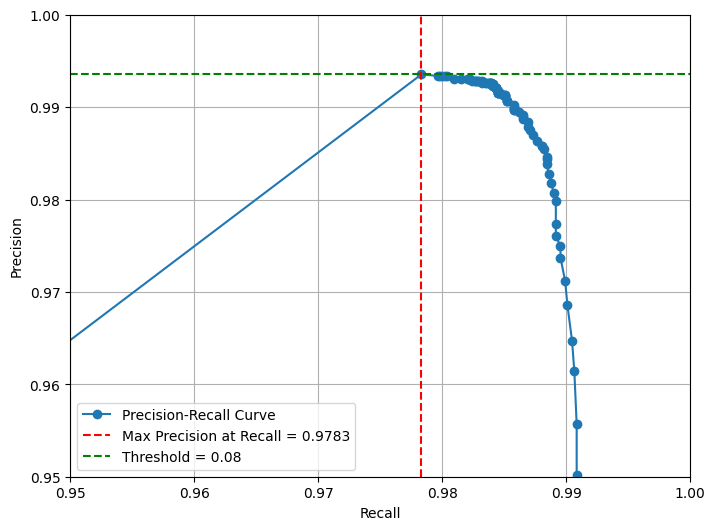

In [36]:
# As an additional method, we are going to plot the precision (purity) recall (efficiency) curve, to visually see the highest value of purity and recall and the corresponding threshold


thresholds = np.linspace(0, 1, 101)  #

precisions = []
recalls = []

# Computing precision and recall for each threshold
for threshold in tqdm(thresholds, desc="Calculating Precision-Recall"):
    preds = (probabilities > threshold).astype(int)  # Apply threshold to classify
    precision2 = precision_score(all_labels, preds, zero_division=0)
    recall2 = recall_score(all_labels, preds, zero_division=0)
    
    precisions.append(precision2)
    recalls.append(recall2)

# Find the index of the maximum precision, to determine the corresponding value of recall and threshold
max_precision_index = np.argmax(precisions)
max_precision = precisions[max_precision_index]
corresponding_recall = recalls[max_precision_index]
max_threshold = thresholds[max_precision_index]


plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions, marker='o', label='Precision-Recall Curve')
plt.axvline(x=corresponding_recall, color='r', linestyle='--', label=f'Max Precision at Recall = {corresponding_recall:.4f}')
plt.axhline(y=max_precision, color='green', linestyle='--', label=f'Threshold = {best_threshold:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('')
plt.grid(True)
plt.legend()
plt.xlim(0.95,1)
plt.ylim(0.95,1)
plt.savefig("precision_recall_curve.png")
plt.show()


## Determining The amount of Li and Po in the Phys dataset

### We first initialize the SignalsDatset by feeding the Phys datset and then initialize the dataloader, we want to estimate number of 1s and 0s but we have to define the threshold, we can apply the results of the previous calculation to ensure 95% precision or doing it normally and use a threshold of 0.5

In [37]:
phys_data = Phys['data_array'][:,:,5000:6000]
phys_dataset = SignalsDataset(phys_data)
phys_loader = DataLoader(phys_dataset, batch_size=batch_size, shuffle=False)

Initializing dataset...


Processing data: 100%|██████████| 24000/24000 [00:00<00:00, 68115.70it/s]


In [38]:
# PREDICTING ON PHYS DATSET

thresholds = [0.5,best_threshold] #estimating with both the conventional threshold of 0.5 and the one that insures less than 5% contamination of Po
model.eval()
with torch.no_grad():
    for threshold in thresholds:
        all_preds = []
        for data in tqdm(phys_loader, desc="Inference"):
            data = data.to(device)
            outputs = model(data)
            preds = (outputs > threshold).int()  
            all_preds.extend(preds.cpu().numpy())

        # Counting the number of samples labeled as 1 and 0
        num_ones = np.sum(np.array(all_preds) == 1)
        num_zeros = np.sum(np.array(all_preds) == 0)
        
        print(f"Threshold = {threshold}")
        print(f"Number of waveforms labeled as 1 (Li): {num_ones}")
        print(f"Number of waveforms labeled as 0 (Po): {num_zeros}")

Inference: 100%|██████████| 750/750 [00:06<00:00, 114.88it/s]


Threshold = 0.5
Number of waveforms labeled as 1 (Li): 236
Number of waveforms labeled as 0 (Po): 23764


Inference: 100%|██████████| 750/750 [00:06<00:00, 115.64it/s]


Threshold = 0.08
Number of waveforms labeled as 1 (Li): 1471
Number of waveforms labeled as 0 (Po): 22529


In [ ]:
#delete phys_dataset in case additional ram is required
del phys_dataset

## Epistemic Uncertainty check

### We used montecarlo dropout to check the epistemic uncertainty, in which we try to estaimate the mean of the predicted output probabilities along with their error (uncertainity), where in this case the uncertainity is the variance. It was chosen for epistemic uncertainty because it provides a practical way to approximate Bayesian inference in neural networks. By performing multiple stochastic forward passes with dropout enabled at inference, MC Dropout captures the model's uncertainty about its weights, which reflects the epistemic uncertainty.

In [39]:
#Montecarlo dropout class to measure epistemic uncertainty in the model.

"""
This class performs Monte Carlo Dropout for uncertainty estimation with progress tracking. It takes as input the model and the data loader along with num_samples argument, which basically defines how many output probabilties will be for each sample, with which the mean and the uncertainty will
be calculated.
"""

def MCDO(model, data_loader, num_samples=10):
    model.train()
    all_predictions = []
    with torch.no_grad():  #  we disable gradient updates as they not needed
        for batch in tqdm(data_loader, desc="Processing Batches"):
            #  We handle cases where labels are included in the batch
            if isinstance(batch, (list, tuple)):
                inputs, _ = batch  # This  ignores labels
            else:
                inputs = batch
            
            inputs = inputs.to(next(model.parameters()).device)  
            predictions = []
            for _ in tqdm(range(num_samples), desc="MC Samples", leave=False): #preciting a number of times for each batch of samples equal to num_samples
                preds = model(inputs) #predictions
                predictions.append(preds.cpu().numpy())
            all_predictions.append(np.stack(predictions, axis=0))
    all_predictions = np.concatenate(all_predictions, axis=1)  # Shape: [num_samples, total_samples, num_classes]
    

    mean_predictions = all_predictions.mean(axis=0)  # calculating mean
    uncertainty = all_predictions.var(axis=0)        # calculating uncertainty (variance)
    
    return mean_predictions, uncertainty # returns mean and uncertainty in prediction.


In [40]:

# Perform Monte Carlo Dropout
num_mc_samples = 10 #Arbitrary, could add more or less, recommended to put less to run faster, and more to have more statistics when calculaing the mean and variance of each sample.
mean_preds, uncertainty = MCDO(model, test_loader, num_samples=num_mc_samples)


print("Mean Predictions:", mean_preds)
print("Uncertainty (Variance):", uncertainty)


# Simple check to see if there are lots of samples with relatively high uncertainty

uncertainty_threshold = 0.05  # we chose to check how many samples have uncertainty higher than 0.05, but we do a more elaborate research on the distribution of uncertainities in each sample in the next cell
high_uncertainty_samples = (uncertainty > uncertainty_threshold).sum()

print(f"Number of samples with uncertainty greater than {uncertainty_threshold}: {high_uncertainty_samples}")




MC Samples:   0%|          | 0/10 [00:00<?, ?it/s]
                                                  
MC Samples:   0%|          | 0/10 [00:00<?, ?it/s]
                                                  
MC Samples:   0%|          | 0/10 [00:00<?, ?it/s]
                                                  
MC Samples:   0%|          | 0/10 [00:00<?, ?it/s]
                                                  
MC Samples:   0%|          | 0/10 [00:00<?, ?it/s]
                                                  
MC Samples:   0%|          | 0/10 [00:00<?, ?it/s]
                                                  
MC Samples:   0%|          | 0/10 [00:00<?, ?it/s]
                                                  
MC Samples:   0%|          | 0/10 [00:00<?, ?it/s]
                                                  
MC Samples:   0%|          | 0/10 [00:00<?, ?it/s]
                                                  
MC Samples:   0%|          | 0/10 [00:00<?, ?it/s]
                               

Mean Predictions: [[0.00514301]
 [0.99715316]
 [0.9977892 ]
 ...
 [0.02073073]
 [0.01060617]
 [0.01780429]]
Uncertainty (Variance): [[1.1903215e-05]
 [1.1077870e-05]
 [4.8671709e-06]
 ...
 [4.8378375e-04]
 [4.3239437e-05]
 [1.2773534e-04]]
Number of samples with uncertainty greater than 0.05: 37


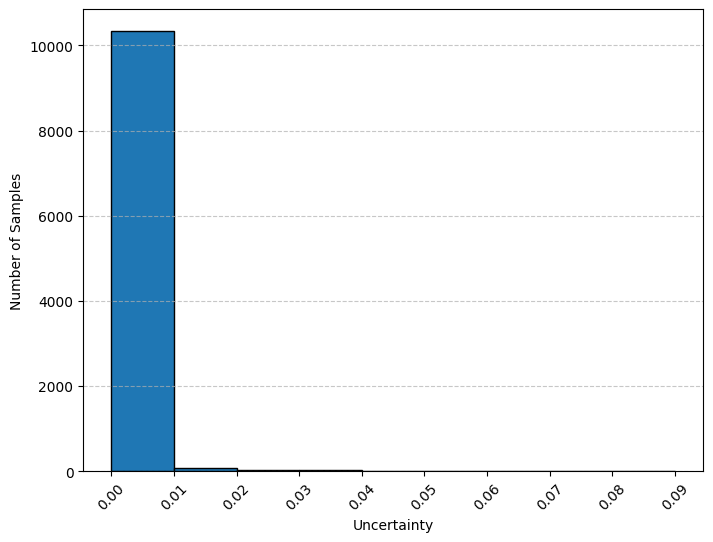

Interval 0.00 to 0.01: 98.22%
Interval 0.01 to 0.02: 0.80%
Interval 0.02 to 0.03: 0.28%
Interval 0.03 to 0.04: 0.26%
Interval 0.04 to 0.05: 0.10%
Interval 0.05 to 0.06: 0.08%
Interval 0.06 to 0.07: 0.06%
Interval 0.07 to 0.08: 0.07%
Interval 0.08 to 0.09: 0.04%


'\nWe can clearly see that most samples have uncertainty between 0 and 0.01\n'

In [41]:
# What we did is to basically get the mean probabilities for each sample along with the uncertainity in the prediction (variance) we would like to visulaize this results more, to see how the sample's uncertainties are distributed

# We do this by plotting a histogram of the distribution of the samples as function of their uncertainty calculated via monte carlo dropout

bins = np.arange(0, 0.1, 0.01)  
flattened_uncertainty = uncertainty.flatten()
counts, bin_edges = np.histogram(flattened_uncertainty, bins=bins)


plt.figure(figsize=(8, 6))
plt.bar(bin_edges[:-1], counts, width=0.01, edgecolor='black', align='edge')
plt.xlabel('Uncertainty')
plt.ylabel('Number of Samples')
plt.title('')
plt.xticks(bin_edges, rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig("distribution_uncertainty_values.png")
plt.show()

# Calculation of percentage of samples in in each bin interval
total_samples = len(flattened_uncertainty)
percentages = (counts / total_samples) * 100
for i in range(len(bins) - 1):
    print(f"Interval {bins[i]:.2f} to {bins[i+1]:.2f}: {percentages[i]:.2f}%")

"""
We can clearly see that most samples have uncertainty between 0 and 0.01
"""


## Summary


In [65]:
print(f"""Using a convolusional network, a model was trained, to differentiate between the Li and Po waveforms/signals, From the training, it is clear that since the first epoch, there are good values of train loss and train accuracy, but there is improvement till the third
epoch, then the validation loss and accuracy become unstable, hence it is decided to stop training after third epoch. After training, testing of the model was done where we obtain a test accuracy of {accuracy * 100:.4f}%, which satisfies the requirement of being higher than 80% to be
considered successful. Afterwards, to insure that model has 5% contamination in Po (or less), we tweaked the threshold, so that we get a purity of at least 95% in selecting Li samples and highest recall possible, where we obtaine a value of threshold of  {best_threshold:.2f}, with purity
 of {precision*100:.4f}% and recall of {recall*100:.4f}%, obtaining a contaminaton rate of {contamination_rate*100:.4f}%. Finally the epistemic uncertainty for the model was calculated using Monte carlo dropout, to calculate the mean and the uncertaqinty(variance) of each sample,
  resulting in most sample having uncertainties of less than 0.01.""")

Using a convolusional network, a model was trained, to differentiate between the Li and Po waveforms/signals, From the training, it is clear that since the first epoch, there are good values of train loss and train accuracy, but there is improvement till the third
epoch, then the validation loss and accuracy become unstable, hence it is decided to stop training after third epoch. After training, testing of the model was done where we obtain a test accuracy of 98.6222%, which satisfies the requirement of being higher than 80% to be
considered successful. Afterwards, to insure that model has 5% contamination in Po (or less), we tweaked the threshold, so that we get a purity of at least 95% in selecting Li samples and highest recall possible, where we obtaine a value of threshold of  0.08, with purity
 of 95.1373% and recall of 99.0288%, obtaining a contaminaton rate of 4.8627%. Finally the epistemic uncertainty for the model was calculated using Monte carlo dropout, to calculate the mean

## Final Notes
### Although a high test accuracy was obtained, there is always room for improvement, weather by optimizing the code or fine-tuning the classifier. Some of the things which may be adjusted is the learning rate to make the training go faster or the batch_size. The number of layers as well could be changed, increasing or decreasing and also changing the number of channels in each layer. Another option is to try another classifier like an RNN which shoud be appropiate for classifing pulses/signals, the choice of using a CNN was based as mentioned earlier on the fact that a pulse could be in a certain sense described as a figure, but instead of working with 2d convolusion layers, we work with 1d convolusions. 